In [1]:
# %%
import torch
from torch import nn
import numpy as np

from pit.dynamics.dynamic_bicycle import DynamicBicycle
from pit.integration import Euler, RK4

import matplotlib.pyplot as plt
import json

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(DEVICE)

# input parameters
map_name = 'SaoPaulo'  # Nuerburgring,  SaoPaulo
lap_number = 2  # 1 - faster, 2 - slower
friction = '1-1'  # '1-1' - mu_x = 1.1, '0-7' - mu_x = 0.7

# visualization
with open('dataset_%s_%s_lap%s.json' % (friction, map_name, lap_number), 'r') as f:
    data = json.load(f)

cpu


In [2]:
# %%
timestep = 0.01
assert(data['time'][1] - data['time'][0] - timestep < 0.001)
x = torch.tensor(data['x'])
y = torch.tensor(data['y'])
yaw = torch.tensor(data['yaw'])
vx = torch.tensor(data['vx'])
vy = torch.tensor(data['vy'])
yaw_rate = torch.tensor(data['yaw_rate'])
steer_angle = torch.tensor(data['steer_angle'])
drive_force = torch.tensor(data['drive_force'])
steer_speed = torch.tensor(data['steer_speed'])

In [3]:
# %%
initial_state = torch.tensor([x[0],y[0],yaw[0],vx[0],vy[0],yaw_rate[0],steer_angle[0]]).to(DEVICE)
control_inputs = torch.vstack([drive_force, steer_speed]).T
control_inputs = control_inputs.contiguous().to(DEVICE)
output_states = torch.vstack([x, y, yaw, vx, vy, yaw_rate, steer_angle]).T
target_states = output_states[1:]
target_states = target_states.contiguous().to(DEVICE)

print(f"Inputs size: {control_inputs.shape} | States size: {target_states.shape}")

Inputs size: torch.Size([22486, 2]) | States size: torch.Size([22486, 7])


In [5]:
# %%
STEP_SIZE=10
TICKS_IN_STEP=50
state_dims = initial_state.shape[0]
input_dims = control_inputs.shape[-1]
total_steps = (control_inputs.shape[0]-TICKS_IN_STEP-1)//STEP_SIZE

batched_initial_states = torch.zeros((total_steps, state_dims), device=DEVICE)
batched_control_inputs = torch.zeros((total_steps, TICKS_IN_STEP, input_dims), device=DEVICE)
batched_target_states = torch.zeros((total_steps, TICKS_IN_STEP, state_dims), device=DEVICE)

for step in range(total_steps):
    batched_initial_states[step] = output_states[step*STEP_SIZE]
    batched_control_inputs[step] = control_inputs[step*STEP_SIZE:(step*STEP_SIZE)+TICKS_IN_STEP]
    batched_target_states[step] = output_states[(step*STEP_SIZE)+1:(step*STEP_SIZE)+TICKS_IN_STEP+1]

print(f"Batched Inputs size: {batched_control_inputs.shape} | Batched States size: {batched_target_states.shape}")

Batched Inputs size: torch.Size([2243, 50, 2]) | Batched States size: torch.Size([2243, 50, 7])


In [6]:
# %%
dataset = torch.utils.data.TensorDataset(batched_initial_states, batched_control_inputs, batched_target_states)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True)

In [23]:
# %%
params = {
    # axes distances
    'lf': 0.88392,  # distance from spring mass center of gravity to front axle [m]  LENA
    'lr': 1.50876,  # distance from spring mass center of gravity to rear axle [m]  LENB

    # moments of inertia of sprung mass
    # masses
    'Iz': 1538.853371,  # moment of inertia for sprung mass in yaw [kg m^2]  IZZ
    'mass': 1225.887,  # vehicle mass [kg]  MASS

    # Pacejka tire force parameters
    'Df': 3709.08227,  # [rad/m]  DF
    'Cf': 1.3507,
    'Bf': 16.2216,
    'Dr': 3709.08227,  # [rad/m]  DR
    'Cr': 1.3507,
    'Br': 16.2216,
    'Cm': 0.3777,
    'Cr0': 2.1469,
    'Cr2': 0.0,
}
params.update({
    "lf" : 0.8839200139045715,
	"lr" : 1.5087599754333496,
	"Iz" : 1538.8533935546875,
	"mass" : 1225.8848876953125,
	"Df" : 3709.082275390625,
	"Cf" : 3.462254762649536,
	"Bf" : 16.504972457885742,
	"Dr" : 3709.082275390625,
	"Cr" : 2.0830910205841064,
	"Br" : 16.302648544311523,
	"Cm" : 0.9561037421226501,
	"Cr0" : 2.1423134803771973,
	"Cr2" : -0.010570406913757324,
})
dynamics = DynamicBicycle(**params)
#dynamics = torch.load("fitted_model.pt")
# <---- FIX PHYSICAL PARAMS     ---->
dynamics.lf.requires_grad = False
dynamics.lr.requires_grad = False
dynamics.mass.requires_grad = True
dynamics.Iz.requires_grad = True
dynamics.Df.requires_grad = True
dynamics.Cf.requires_grad = True
dynamics.Bf.requires_grad = True
dynamics.Dr.requires_grad = True
dynamics.Cr.requires_grad = True
dynamics.Br.requires_grad = True
dynamics.Cm.requires_grad = True
dynamics.Cr0.requires_grad = True
dynamics.Cr2.requires_grad = True
# <----                         ---->
euler_integrator = Euler(dynamics, timestep=timestep)
euler_integrator.to(DEVICE)
rk4_integrator = RK4(dynamics=dynamics, timestep=timestep)
rk4_integrator.to(DEVICE)


RK4(
  (dynamics): DynamicBicycle()
)

In [24]:
with torch.no_grad():
    euler_output_states = euler_integrator(initial_state, control_inputs)


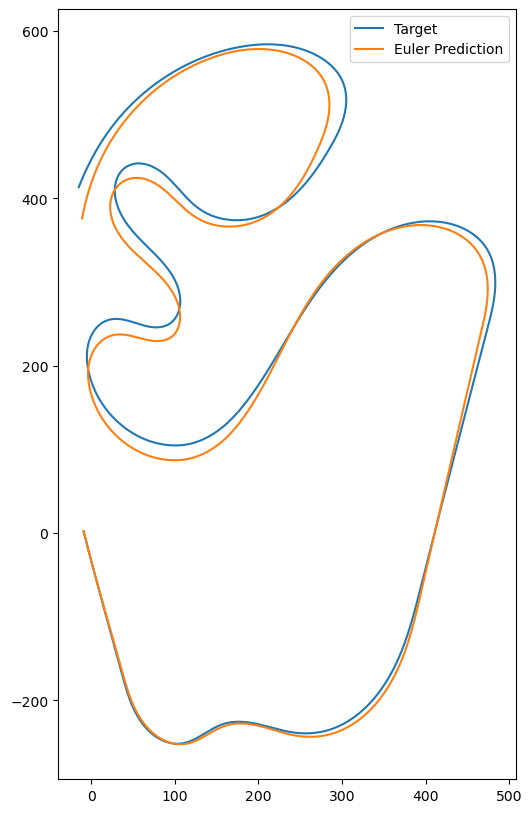

In [25]:
# %%
fig, ax = plt.subplots(1, 1, figsize=(10,10))
LEN=20000
ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target")
ax.plot(euler_output_states[:LEN, 0].detach().cpu().numpy(), euler_output_states[:LEN, 1].detach().cpu().numpy(), label="Euler Prediction")
#ax.plot(rk4_output_states[:LEN, 0].detach().cpu().numpy(), rk4_output_states[:LEN, 1].detach().cpu().numpy(), label="RK4 Prediction")
ax.set_aspect(1.0)
ax.legend()

In [26]:
# %%
from tqdm.auto import tqdm
EPOCHS = 100
integrator = euler_integrator
optimizer = torch.optim.SGD(integrator.parameters(), lr=1, momentum=0.8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.9)

with torch.no_grad():
        output_states = integrator(initial_state, control_inputs)
        val_loss = torch.nn.functional.l1_loss(output_states, target_states)
print(f"Initialized | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")

losses = list()
lrs = list()

for i in tqdm(range(EPOCHS)):
    for initial, inputs, targets in dataloader:
        optimizer.zero_grad()
        output_states = integrator(initial, inputs)
        loss = torch.nn.functional.l1_loss(output_states, targets)
        loss.backward()
        optimizer.step()
    #for name, param in integrator.named_parameters():
    #    if param.requires_grad:
    #        print(name, param.data, param.grad)
    if i%20 == 0 and False:
        with torch.no_grad():
            output_states = integrator(initial_state, control_inputs)
            val_loss = torch.nn.functional.l1_loss(output_states, target_states)
        fig, ax = plt.subplots(1, 1, figsize=(10,10))
        LEN=20000
        ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target")
        ax.plot(output_states[:LEN, 0].detach().cpu().numpy(), output_states[:LEN, 1].detach().cpu().numpy(), label="Prediction")
        ax.set_aspect(1.0)
        ax.legend()
        plt.show()
        print(f"Epoch: {i} | Training Loss: {loss.item()} | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
    with torch.no_grad():
        output_states = integrator(batched_initial_states,batched_control_inputs)
        val_loss = torch.nn.functional.l1_loss(output_states, batched_target_states)
        losses.append(val_loss.item())
    print(f"Epoch: {i} | Training Loss: {loss.item()} | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step(val_loss)


Initialized | Validation Loss: 4.108921527862549 | LR: 1


  1%|          | 1/100 [00:01<03:00,  1.83s/it]

Epoch: 0 | Training Loss: 0.010483800433576107 | Validation Loss: 0.013307969085872173 | LR: 1


  2%|▏         | 2/100 [00:03<02:39,  1.62s/it]

Epoch: 1 | Training Loss: 0.013066355139017105 | Validation Loss: 0.013309493660926819 | LR: 1


  3%|▎         | 3/100 [00:04<02:13,  1.37s/it]

Epoch: 2 | Training Loss: 0.0063818893395364285 | Validation Loss: 0.013307862915098667 | LR: 1


  4%|▍         | 4/100 [00:05<01:56,  1.21s/it]

Epoch: 3 | Training Loss: 0.010290703736245632 | Validation Loss: 0.013308409601449966 | LR: 1


  5%|▌         | 5/100 [00:06<01:50,  1.16s/it]

Epoch: 4 | Training Loss: 0.010090772062540054 | Validation Loss: 0.013308057561516762 | LR: 1


  6%|▌         | 6/100 [00:07<01:41,  1.08s/it]

Epoch: 5 | Training Loss: 0.006283552851527929 | Validation Loss: 0.013308246619999409 | LR: 1


  7%|▋         | 7/100 [00:08<01:34,  1.02s/it]

Epoch: 6 | Training Loss: 0.020820194855332375 | Validation Loss: 0.013310052454471588 | LR: 1


  8%|▊         | 8/100 [00:09<01:31,  1.01it/s]

Epoch: 7 | Training Loss: 0.010652396827936172 | Validation Loss: 0.013308333232998848 | LR: 1


  9%|▉         | 9/100 [00:10<01:32,  1.02s/it]

Epoch: 8 | Training Loss: 0.010718842037022114 | Validation Loss: 0.013309553265571594 | LR: 1


 10%|█         | 10/100 [00:11<01:28,  1.02it/s]

Epoch: 9 | Training Loss: 0.01856227032840252 | Validation Loss: 0.013315566815435886 | LR: 1


 11%|█         | 11/100 [00:12<01:25,  1.04it/s]

Epoch: 10 | Training Loss: 0.018644435331225395 | Validation Loss: 0.013308461755514145 | LR: 1


 12%|█▏        | 12/100 [00:12<01:23,  1.05it/s]

Epoch: 11 | Training Loss: 0.006015941500663757 | Validation Loss: 0.01331085991114378 | LR: 1


 13%|█▎        | 13/100 [00:13<01:22,  1.05it/s]

Epoch: 12 | Training Loss: 0.010485486127436161 | Validation Loss: 0.013308821246027946 | LR: 0.9


 14%|█▍        | 14/100 [00:14<01:20,  1.06it/s]

Epoch: 13 | Training Loss: 0.0170464888215065 | Validation Loss: 0.013308544643223286 | LR: 0.9


 15%|█▌        | 15/100 [00:15<01:23,  1.02it/s]

Epoch: 14 | Training Loss: 0.011396575719118118 | Validation Loss: 0.013308313675224781 | LR: 0.9


 16%|█▌        | 16/100 [00:16<01:19,  1.05it/s]

Epoch: 15 | Training Loss: 0.007222714368253946 | Validation Loss: 0.01330802496522665 | LR: 0.9


 17%|█▋        | 17/100 [00:17<01:17,  1.07it/s]

Epoch: 16 | Training Loss: 0.02055060677230358 | Validation Loss: 0.013309448026120663 | LR: 0.9


 18%|█▊        | 18/100 [00:18<01:15,  1.09it/s]

Epoch: 17 | Training Loss: 0.012491470202803612 | Validation Loss: 0.01330854743719101 | LR: 0.9


 19%|█▉        | 19/100 [00:19<01:14,  1.09it/s]

Epoch: 18 | Training Loss: 0.017072584480047226 | Validation Loss: 0.013308239169418812 | LR: 0.9


 20%|██        | 20/100 [00:20<01:14,  1.07it/s]

Epoch: 19 | Training Loss: 0.013164003379642963 | Validation Loss: 0.013307935558259487 | LR: 0.9


 21%|██        | 21/100 [00:21<01:14,  1.06it/s]

Epoch: 20 | Training Loss: 0.026228338479995728 | Validation Loss: 0.013308952562510967 | LR: 0.9


 22%|██▏       | 22/100 [00:22<01:12,  1.07it/s]

Epoch: 21 | Training Loss: 0.008587656542658806 | Validation Loss: 0.013310408219695091 | LR: 0.9


 23%|██▎       | 23/100 [00:23<01:11,  1.08it/s]

Epoch: 22 | Training Loss: 0.022847484797239304 | Validation Loss: 0.013309192843735218 | LR: 0.9


 24%|██▍       | 24/100 [00:24<01:10,  1.08it/s]

Epoch: 23 | Training Loss: 0.017986485734581947 | Validation Loss: 0.013309555128216743 | LR: 0.81


 25%|██▌       | 25/100 [00:25<01:13,  1.03it/s]

Epoch: 24 | Training Loss: 0.01825558766722679 | Validation Loss: 0.01330817025154829 | LR: 0.81


 26%|██▌       | 26/100 [00:26<01:10,  1.05it/s]

Epoch: 25 | Training Loss: 0.010066209360957146 | Validation Loss: 0.013309411704540253 | LR: 0.81


 27%|██▋       | 27/100 [00:27<01:07,  1.08it/s]

Epoch: 26 | Training Loss: 0.010005476884543896 | Validation Loss: 0.013308441266417503 | LR: 0.81


 28%|██▊       | 28/100 [00:27<01:06,  1.08it/s]

Epoch: 27 | Training Loss: 0.025624660775065422 | Validation Loss: 0.013309625908732414 | LR: 0.81


 29%|██▉       | 29/100 [00:28<01:04,  1.10it/s]

Epoch: 28 | Training Loss: 0.009152613580226898 | Validation Loss: 0.013308006338775158 | LR: 0.81


 30%|███       | 30/100 [00:29<01:03,  1.10it/s]

Epoch: 29 | Training Loss: 0.008895600214600563 | Validation Loss: 0.013308482244610786 | LR: 0.81


 31%|███       | 31/100 [00:30<01:02,  1.10it/s]

Epoch: 30 | Training Loss: 0.00918614398688078 | Validation Loss: 0.013308363035321236 | LR: 0.81


 32%|███▏      | 32/100 [00:31<01:01,  1.10it/s]

Epoch: 31 | Training Loss: 0.012235392816364765 | Validation Loss: 0.013307866640388966 | LR: 0.81


 33%|███▎      | 33/100 [00:32<01:00,  1.11it/s]

Epoch: 32 | Training Loss: 0.007174105383455753 | Validation Loss: 0.013307880610227585 | LR: 0.81


 34%|███▍      | 34/100 [00:33<00:59,  1.11it/s]

Epoch: 33 | Training Loss: 0.006958488840609789 | Validation Loss: 0.013307987712323666 | LR: 0.81


 35%|███▌      | 35/100 [00:34<01:05,  1.00s/it]

Epoch: 34 | Training Loss: 0.01232365146279335 | Validation Loss: 0.013307969085872173 | LR: 0.7290000000000001


 36%|███▌      | 36/100 [00:35<01:01,  1.03it/s]

Epoch: 35 | Training Loss: 0.01281755231320858 | Validation Loss: 0.013307840563356876 | LR: 0.7290000000000001


 37%|███▋      | 37/100 [00:36<00:59,  1.05it/s]

Epoch: 36 | Training Loss: 0.01413414254784584 | Validation Loss: 0.013308793306350708 | LR: 0.7290000000000001


 38%|███▊      | 38/100 [00:37<00:57,  1.08it/s]

Epoch: 37 | Training Loss: 0.012083937413990498 | Validation Loss: 0.01330927200615406 | LR: 0.7290000000000001


 39%|███▉      | 39/100 [00:38<00:56,  1.09it/s]

Epoch: 38 | Training Loss: 0.018029462546110153 | Validation Loss: 0.013308189809322357 | LR: 0.7290000000000001


 40%|████      | 40/100 [00:39<00:59,  1.01it/s]

Epoch: 39 | Training Loss: 0.014065338298678398 | Validation Loss: 0.013308858498930931 | LR: 0.7290000000000001


 41%|████      | 41/100 [00:40<00:56,  1.04it/s]

Epoch: 40 | Training Loss: 0.006276439409703016 | Validation Loss: 0.01330911461263895 | LR: 0.7290000000000001


 42%|████▏     | 42/100 [00:41<00:54,  1.07it/s]

Epoch: 41 | Training Loss: 0.016599176451563835 | Validation Loss: 0.013308937661349773 | LR: 0.7290000000000001


 43%|████▎     | 43/100 [00:41<00:52,  1.08it/s]

Epoch: 42 | Training Loss: 0.01599014550447464 | Validation Loss: 0.013307959772646427 | LR: 0.7290000000000001


 44%|████▍     | 44/100 [00:42<00:51,  1.09it/s]

Epoch: 43 | Training Loss: 0.012066518887877464 | Validation Loss: 0.013309684582054615 | LR: 0.7290000000000001


 45%|████▌     | 45/100 [00:43<00:51,  1.08it/s]

Epoch: 44 | Training Loss: 0.005901239812374115 | Validation Loss: 0.013309014029800892 | LR: 0.7290000000000001


 46%|████▌     | 46/100 [00:45<00:54,  1.01s/it]

Epoch: 45 | Training Loss: 0.006129713263362646 | Validation Loss: 0.013309244066476822 | LR: 0.6561000000000001


 47%|████▋     | 47/100 [00:46<01:05,  1.23s/it]

Epoch: 46 | Training Loss: 0.012060173787176609 | Validation Loss: 0.013308308087289333 | LR: 0.6561000000000001


 48%|████▊     | 48/100 [00:48<01:05,  1.27s/it]

Epoch: 47 | Training Loss: 0.012407210655510426 | Validation Loss: 0.013308621942996979 | LR: 0.6561000000000001


 49%|████▉     | 49/100 [00:49<00:59,  1.18s/it]

Epoch: 48 | Training Loss: 0.013736002147197723 | Validation Loss: 0.013308954425156116 | LR: 0.6561000000000001


 50%|█████     | 50/100 [00:50<00:55,  1.11s/it]

Epoch: 49 | Training Loss: 0.010890219360589981 | Validation Loss: 0.01330815814435482 | LR: 0.6561000000000001


 51%|█████     | 51/100 [00:50<00:51,  1.04s/it]

Epoch: 50 | Training Loss: 0.013488785363733768 | Validation Loss: 0.013308008201420307 | LR: 0.6561000000000001


 52%|█████▏    | 52/100 [00:51<00:50,  1.05s/it]

Epoch: 51 | Training Loss: 0.006159327924251556 | Validation Loss: 0.013308054767549038 | LR: 0.6561000000000001


 53%|█████▎    | 53/100 [00:53<00:49,  1.04s/it]

Epoch: 52 | Training Loss: 0.013567128218710423 | Validation Loss: 0.0133088119328022 | LR: 0.6561000000000001


 54%|█████▍    | 54/100 [00:53<00:46,  1.02s/it]

Epoch: 53 | Training Loss: 0.02004397287964821 | Validation Loss: 0.013308556750416756 | LR: 0.6561000000000001


 55%|█████▌    | 55/100 [00:54<00:44,  1.02it/s]

Epoch: 54 | Training Loss: 0.011997170746326447 | Validation Loss: 0.013308094814419746 | LR: 0.6561000000000001


 56%|█████▌    | 56/100 [00:55<00:43,  1.00it/s]

Epoch: 55 | Training Loss: 0.011866793967783451 | Validation Loss: 0.013308651745319366 | LR: 0.6561000000000001


 57%|█████▋    | 57/100 [00:56<00:41,  1.04it/s]

Epoch: 56 | Training Loss: 0.015981996431946754 | Validation Loss: 0.01330901961773634 | LR: 0.5904900000000002


 58%|█████▊    | 58/100 [00:57<00:40,  1.05it/s]

Epoch: 57 | Training Loss: 0.010510356165468693 | Validation Loss: 0.013307977467775345 | LR: 0.5904900000000002


 59%|█████▉    | 59/100 [00:58<00:38,  1.07it/s]

Epoch: 58 | Training Loss: 0.010398466140031815 | Validation Loss: 0.01330826710909605 | LR: 0.5904900000000002


 60%|██████    | 60/100 [00:59<00:36,  1.09it/s]

Epoch: 59 | Training Loss: 0.0070664850063622 | Validation Loss: 0.013308017514646053 | LR: 0.5904900000000002


 61%|██████    | 61/100 [01:00<00:35,  1.09it/s]

Epoch: 60 | Training Loss: 0.01334705762565136 | Validation Loss: 0.013308004476130009 | LR: 0.5904900000000002


 62%|██████▏   | 62/100 [01:01<00:34,  1.10it/s]

Epoch: 61 | Training Loss: 0.01329473964869976 | Validation Loss: 0.013308562338352203 | LR: 0.5904900000000002


 63%|██████▎   | 63/100 [01:02<00:33,  1.09it/s]

Epoch: 62 | Training Loss: 0.006353756412863731 | Validation Loss: 0.01330988947302103 | LR: 0.5904900000000002


 64%|██████▍   | 64/100 [01:03<00:32,  1.11it/s]

Epoch: 63 | Training Loss: 0.014808795414865017 | Validation Loss: 0.013307981193065643 | LR: 0.5904900000000002


 65%|██████▌   | 65/100 [01:03<00:31,  1.11it/s]

Epoch: 64 | Training Loss: 0.013464870862662792 | Validation Loss: 0.013308617286384106 | LR: 0.5904900000000002


 66%|██████▌   | 66/100 [01:05<00:33,  1.02it/s]

Epoch: 65 | Training Loss: 0.01930922083556652 | Validation Loss: 0.013307958841323853 | LR: 0.5904900000000002


 67%|██████▋   | 67/100 [01:06<00:31,  1.05it/s]

Epoch: 66 | Training Loss: 0.012241293676197529 | Validation Loss: 0.013307911343872547 | LR: 0.5904900000000002


 68%|██████▊   | 68/100 [01:06<00:29,  1.08it/s]

Epoch: 67 | Training Loss: 0.010158518329262733 | Validation Loss: 0.013308006338775158 | LR: 0.5314410000000002


 69%|██████▉   | 69/100 [01:07<00:28,  1.10it/s]

Epoch: 68 | Training Loss: 0.009700140915811062 | Validation Loss: 0.013307955116033554 | LR: 0.5314410000000002


 70%|███████   | 70/100 [01:08<00:26,  1.11it/s]

Epoch: 69 | Training Loss: 0.011143045499920845 | Validation Loss: 0.013308463618159294 | LR: 0.5314410000000002


 71%|███████   | 71/100 [01:09<00:25,  1.13it/s]

Epoch: 70 | Training Loss: 0.012254301458597183 | Validation Loss: 0.013308132998645306 | LR: 0.5314410000000002


 72%|███████▏  | 72/100 [01:10<00:26,  1.04it/s]

Epoch: 71 | Training Loss: 0.012647422961890697 | Validation Loss: 0.01330785546451807 | LR: 0.5314410000000002


 73%|███████▎  | 73/100 [01:11<00:24,  1.08it/s]

Epoch: 72 | Training Loss: 0.007336893118917942 | Validation Loss: 0.01330801472067833 | LR: 0.5314410000000002


 74%|███████▍  | 74/100 [01:12<00:23,  1.10it/s]

Epoch: 73 | Training Loss: 0.012542882934212685 | Validation Loss: 0.013309033587574959 | LR: 0.5314410000000002


 75%|███████▌  | 75/100 [01:13<00:23,  1.07it/s]

Epoch: 74 | Training Loss: 0.02357052080333233 | Validation Loss: 0.013308262452483177 | LR: 0.5314410000000002


 76%|███████▌  | 76/100 [01:14<00:23,  1.04it/s]

Epoch: 75 | Training Loss: 0.009406630881130695 | Validation Loss: 0.013308444991707802 | LR: 0.5314410000000002


 77%|███████▋  | 77/100 [01:15<00:21,  1.07it/s]

Epoch: 76 | Training Loss: 0.014122332446277142 | Validation Loss: 0.013309451751410961 | LR: 0.5314410000000002


 78%|███████▊  | 78/100 [01:16<00:20,  1.08it/s]

Epoch: 77 | Training Loss: 0.024400873109698296 | Validation Loss: 0.013308333232998848 | LR: 0.5314410000000002


 79%|███████▉  | 79/100 [01:17<00:19,  1.10it/s]

Epoch: 78 | Training Loss: 0.008848783560097218 | Validation Loss: 0.013308043591678143 | LR: 0.47829690000000014


 80%|████████  | 80/100 [01:17<00:17,  1.12it/s]

Epoch: 79 | Training Loss: 0.009921830147504807 | Validation Loss: 0.01330825500190258 | LR: 0.47829690000000014


 81%|████████  | 81/100 [01:18<00:16,  1.13it/s]

Epoch: 80 | Training Loss: 0.01353179570287466 | Validation Loss: 0.013307958841323853 | LR: 0.47829690000000014


 82%|████████▏ | 82/100 [01:19<00:15,  1.14it/s]

Epoch: 81 | Training Loss: 0.01027410477399826 | Validation Loss: 0.013307955116033554 | LR: 0.47829690000000014


 83%|████████▎ | 83/100 [01:20<00:14,  1.15it/s]

Epoch: 82 | Training Loss: 0.015043099410831928 | Validation Loss: 0.01330794021487236 | LR: 0.47829690000000014


 84%|████████▍ | 84/100 [01:21<00:13,  1.15it/s]

Epoch: 83 | Training Loss: 0.021401038393378258 | Validation Loss: 0.013307973742485046 | LR: 0.47829690000000014


 85%|████████▌ | 85/100 [01:22<00:14,  1.06it/s]

Epoch: 84 | Training Loss: 0.015435276553034782 | Validation Loss: 0.013307969085872173 | LR: 0.47829690000000014


 86%|████████▌ | 86/100 [01:23<00:13,  1.08it/s]

Epoch: 85 | Training Loss: 0.0075784288346767426 | Validation Loss: 0.013308852910995483 | LR: 0.47829690000000014


 87%|████████▋ | 87/100 [01:24<00:11,  1.11it/s]

Epoch: 86 | Training Loss: 0.012693437747657299 | Validation Loss: 0.013308079913258553 | LR: 0.47829690000000014


 88%|████████▊ | 88/100 [01:25<00:10,  1.11it/s]

Epoch: 87 | Training Loss: 0.00630522146821022 | Validation Loss: 0.01330787967890501 | LR: 0.47829690000000014


 89%|████████▉ | 89/100 [01:26<00:10,  1.08it/s]

Epoch: 88 | Training Loss: 0.010452931746840477 | Validation Loss: 0.013307795859873295 | LR: 0.47829690000000014


 90%|█████████ | 90/100 [01:27<00:10,  1.08s/it]

Epoch: 89 | Training Loss: 0.009203619323670864 | Validation Loss: 0.013308210298418999 | LR: 0.43046721000000016


 91%|█████████ | 91/100 [01:29<00:11,  1.23s/it]

Epoch: 90 | Training Loss: 0.012910762801766396 | Validation Loss: 0.013307925313711166 | LR: 0.43046721000000016


 92%|█████████▏| 92/100 [01:30<00:09,  1.21s/it]

Epoch: 91 | Training Loss: 0.013609605841338634 | Validation Loss: 0.013308092020452023 | LR: 0.43046721000000016


 93%|█████████▎| 93/100 [01:31<00:08,  1.14s/it]

Epoch: 92 | Training Loss: 0.005103683099150658 | Validation Loss: 0.01330842636525631 | LR: 0.43046721000000016


 94%|█████████▍| 94/100 [01:32<00:07,  1.25s/it]

Epoch: 93 | Training Loss: 0.018316954374313354 | Validation Loss: 0.013308144174516201 | LR: 0.43046721000000016


 95%|█████████▌| 95/100 [01:33<00:05,  1.15s/it]

Epoch: 94 | Training Loss: 0.005426554009318352 | Validation Loss: 0.013307852670550346 | LR: 0.43046721000000016


 96%|█████████▌| 96/100 [01:34<00:04,  1.10s/it]

Epoch: 95 | Training Loss: 0.013548784889280796 | Validation Loss: 0.013307896442711353 | LR: 0.43046721000000016


 97%|█████████▋| 97/100 [01:35<00:03,  1.04s/it]

Epoch: 96 | Training Loss: 0.010561477392911911 | Validation Loss: 0.013308010064065456 | LR: 0.43046721000000016


 98%|█████████▊| 98/100 [01:36<00:02,  1.04s/it]

Epoch: 97 | Training Loss: 0.01242764201015234 | Validation Loss: 0.013307922519743443 | LR: 0.43046721000000016


 99%|█████████▉| 99/100 [01:37<00:01,  1.09s/it]

Epoch: 98 | Training Loss: 0.023729192093014717 | Validation Loss: 0.013307834044098854 | LR: 0.43046721000000016


100%|██████████| 100/100 [01:39<00:00,  1.01it/s]

Epoch: 99 | Training Loss: 0.013570856302976608 | Validation Loss: 0.013308019377291203 | LR: 0.43046721000000016


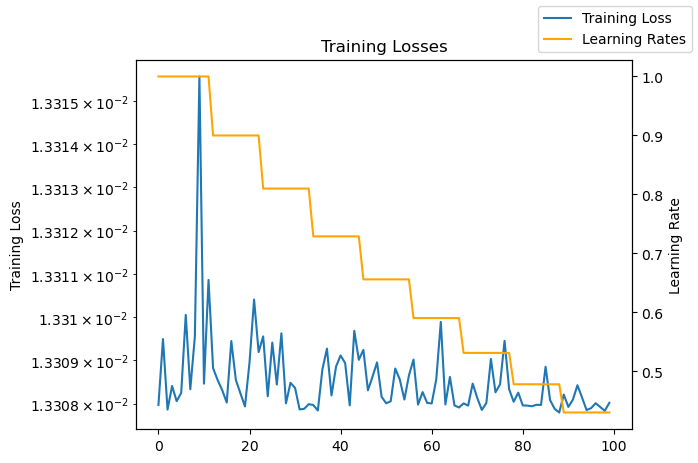

In [27]:
fig, ax = plt.subplots()
ax.plot(losses, label='Training Loss')
ax.set_ylabel("Training Loss")
ax.set_yscale('log')
secax = ax.twinx()
secax.set_ylabel("Learning Rate")
secax.plot(lrs, label="Learning Rates", color='orange')
#secax.set_yscale('log')
ax.set_title("Training Losses")
fig.legend()
plt.show()

In [28]:
# %%
with torch.no_grad():
    output_states = integrator(initial_state, control_inputs)
    val_loss = torch.nn.functional.l1_loss(output_states, target_states)

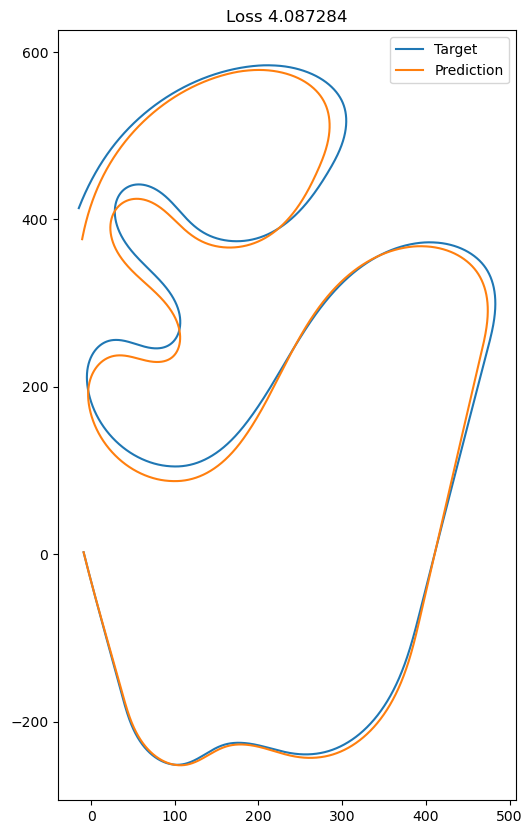

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
LEN=20000
ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target")
ax.plot(output_states[:LEN, 0].detach().cpu().numpy(), output_states[:LEN, 1].detach().cpu().numpy(), label="Prediction")
ax.set_aspect(1.0)
ax.legend()
ax.set_title("Loss {:4f}".format(val_loss.item()))
plt.show()

In [30]:
print("{")
for key in dynamics.state_dict().keys():
    print(f"\t\"{key}\" : {dynamics.state_dict()[key]},")
print("}")

{
	"lf" : 0.8839200139045715,
	"lr" : 1.5087599754333496,
	"Iz" : 1538.8533935546875,
	"mass" : 1225.8848876953125,
	"Df" : 3709.082275390625,
	"Cf" : 3.463547706604004,
	"Bf" : 16.50279426574707,
	"Dr" : 3709.082275390625,
	"Cr" : 2.0817453861236572,
	"Br" : 16.30957794189453,
	"Cm" : 0.9565907120704651,
	"Cr0" : 2.1386544704437256,
	"Cr2" : -0.010349993593990803,
}
